In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_38677/3827359723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"
pred_file = "effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv"
root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file
only_validation = True

In [3]:
pred = pd.DataFrame()

print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, pred_file))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_label_pred"}, inplace=True)

quality_pred = pred[pred.Level == "quality"][["image_id", "Prediction", "quality_label_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]
pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

reading effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv


In [4]:
annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_label_true"}, inplace=True)
annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [5]:
df = pred.join(
    annot[["image_id", "type_true", "quality_label_true", "quality_float_true", "train"]].set_index("image_id"), how="left")
df_test = df[df.train == False]
df = df[df.train == True]

In [6]:
#df

In [7]:
df.groupby(["type_true", "quality_label_true"]).size()

type_true      quality_label_true
asphalt        bad                    238
               excellent              791
               good                  1407
               intermediate           768
concrete       bad                     58
               excellent              310
               good                   340
               intermediate           248
paving_stones  bad                     70
               excellent              360
               good                   989
               intermediate           505
sett           bad                    526
               good                   128
               intermediate           677
unpaved        bad                    339
               intermediate           305
               very_bad               287
dtype: int64

In [8]:
df_test.groupby(["type_true", "quality_label_true"]).size()

type_true      quality_label_true
asphalt        bad                     8
               excellent             180
               good                  289
               intermediate           53
concrete       excellent               4
               good                   10
               intermediate            2
paving_stones  excellent              25
               good                   74
               intermediate           14
sett           bad                    14
               good                    1
               intermediate           17
unpaved        bad                    48
               intermediate           21
               very_bad               16
dtype: int64

In [9]:
df.shape

(8346, 10)

In [10]:
df_test.shape

(776, 10)

In [11]:
df_valid_type = df[df.is_in_validation_type == 1]
df_train_type = df[df.is_in_validation_type == 0]

df_valid_quality = df[df.is_in_validation_quality == 1]
df_train_quality = df[df.is_in_validation_quality == 0]

In [26]:
print(df_valid_type.shape)
print(df_train_type.shape)
print(df_valid_type.shape[0] + df_train_type.shape[0])
print(df_valid_quality.shape)
print(df_train_quality.shape)
print(df_valid_quality.shape[0] + df_train_quality.shape[0])


(1670, 10)
(6676, 10)
8346
(1635, 10)
(6711, 10)
8346


## Global measures

In [12]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

#### global measures for type

In [13]:
# all
gm = compute_measures_cat(df.type_true, df.type_pred)
gm_valid = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
gm_train = compute_measures_cat(df_train_type.type_true, df_train_type.type_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)

,all,validation,train
accuracy,0.98,0.94,0.99


In [22]:
# all
gm = compute_measures_cat(df_test.type_true, df_test.type_pred)
pd.concat([pd.Series(gm, name="all test")], axis=1).round(2)

,all test
accuracy,0.91


#### global measures for quality

In [14]:
# all
gm = compute_measures_float(df.quality_float_true, df.quality_float_pred)
gm_valid = compute_measures_float(df_valid_quality.quality_float_true, df_valid_quality.quality_float_pred)
gm_train = compute_measures_float(df_train_quality.quality_float_true, df_train_quality.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(3)

,all,validation,train
accuracy,0.859,0.630,0.915
correlation,0.946,0.860,0.966
r_square,0.879,0.726,0.917
mse,0.133,0.305,0.091
mae,0.271,0.439,0.230
rmse,0.364,0.552,0.301


In [21]:
# all
gm = compute_measures_float(df_test.quality_float_true, df_test.quality_float_pred)
pd.concat([pd.Series(gm, name="all test")], axis=1).round(3)

,all test
accuracy,0.611
correlation,0.801
r_square,0.635
mse,0.344
mae,0.461
rmse,0.586


## Surface type

In [16]:
#plt.rcParams.update({'font.size': 14})

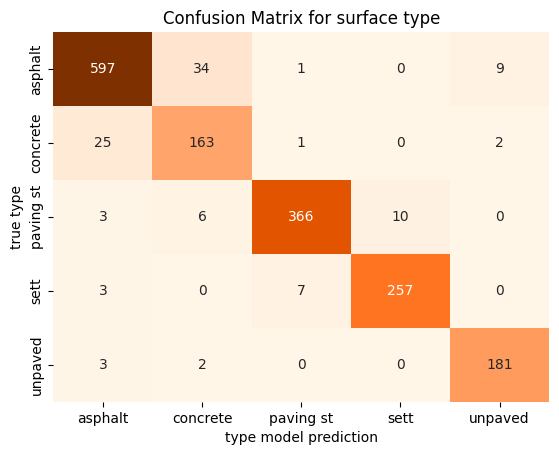

In [18]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

cm = confusion_matrix(df_valid_type.type_true, df_valid_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

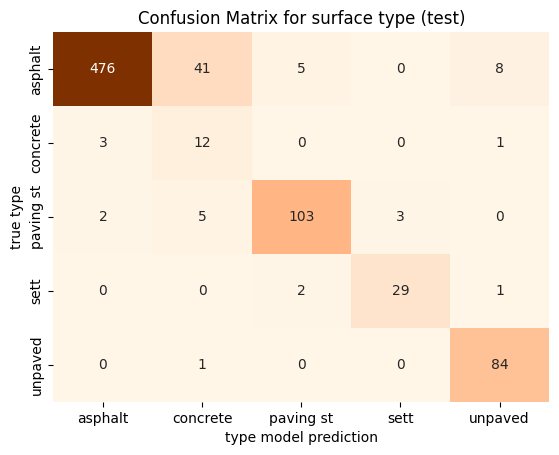

In [19]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

cm = confusion_matrix(df_test.type_true, df_test.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type (test)")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

## Measures for quality by surface type

In [74]:
gm_surface = pd.DataFrame()
for surface in df_valid_quality.type_true.unique():
    df_ = df_valid_quality[df_valid_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.59,0.66,0.63,0.74,0.59
correlation,0.77,0.80,0.71,0.70,0.73
r_square,0.58,0.62,0.48,0.39,0.45
mse,0.32,0.32,0.29,0.24,0.35
rmse,0.57,0.57,0.54,0.49,0.59


## compare float values

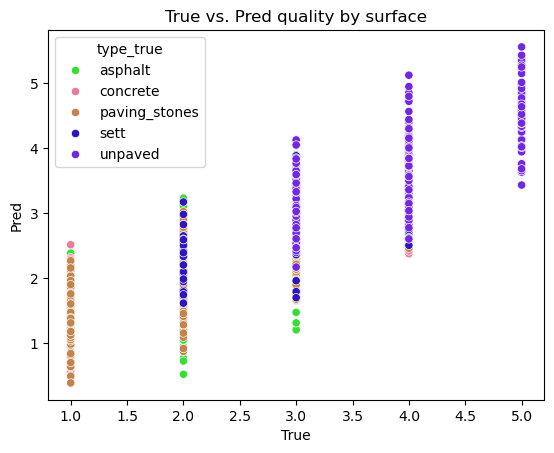

In [75]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df_valid_quality.type_true.unique()}

sns.scatterplot(data=df_valid_quality, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


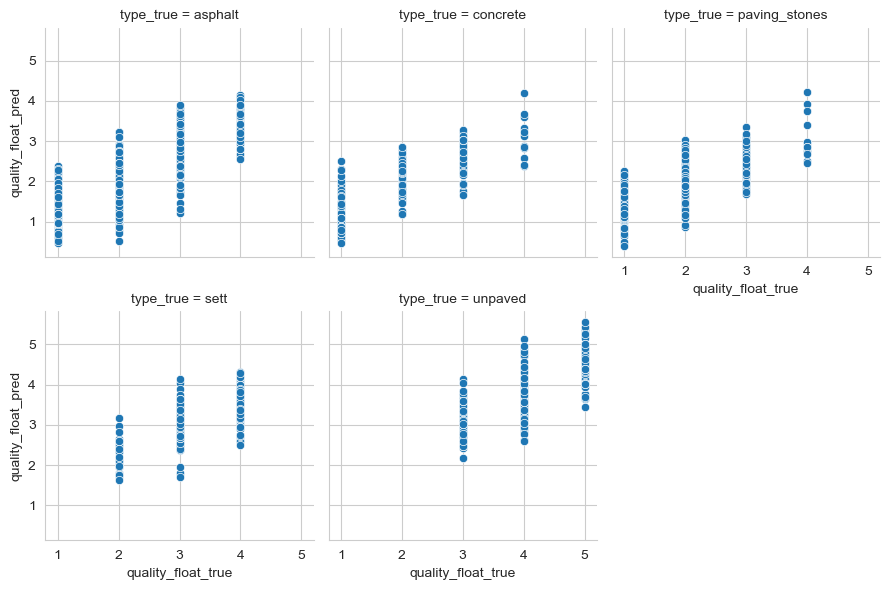

In [76]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [80]:
df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred

**Overall**

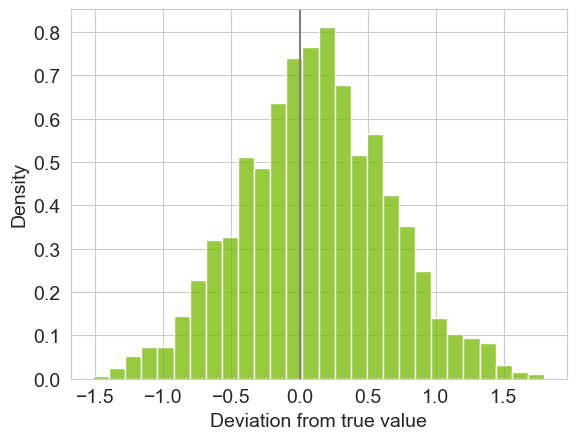

In [182]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [160]:
np.mean(df_valid_quality.deviation)

0.1149677615464645

In [158]:
np.std(df_valid_quality.deviation)


0.5403729757753959

In [171]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1515
True      120
Name: count, dtype: int64

In [173]:
120/len(df_valid_quality)

0.07339449541284404

**by surface**

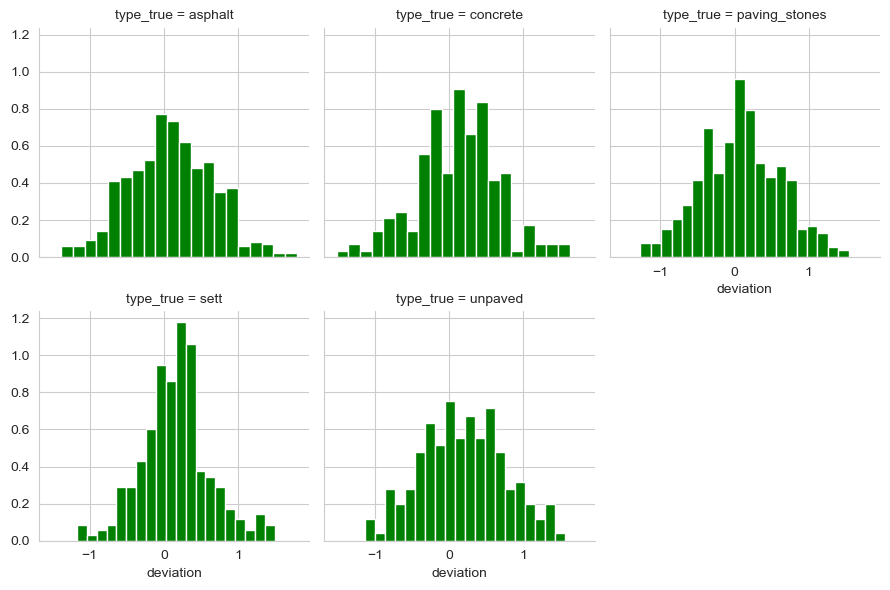

In [82]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

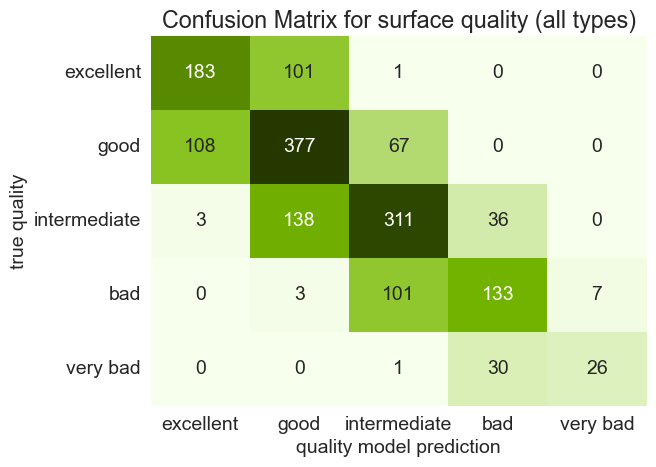

In [185]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_label_true, df_valid_quality.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

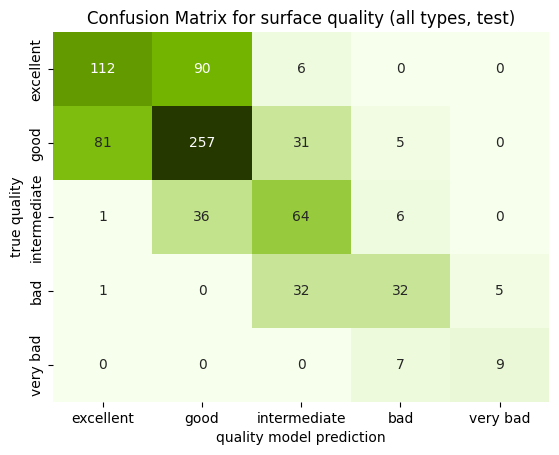

In [23]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_test.quality_label_true, df_test.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types, test)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

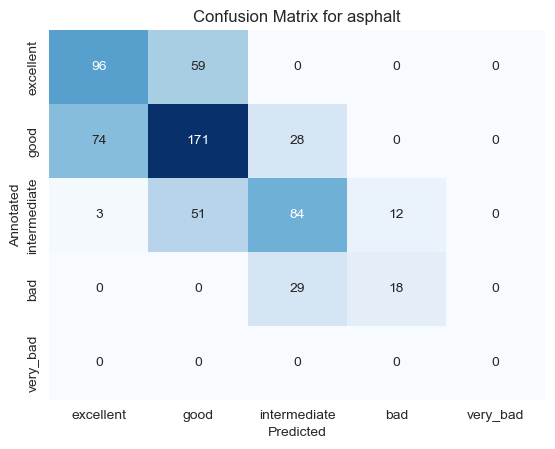

<Figure size 640x480 with 0 Axes>

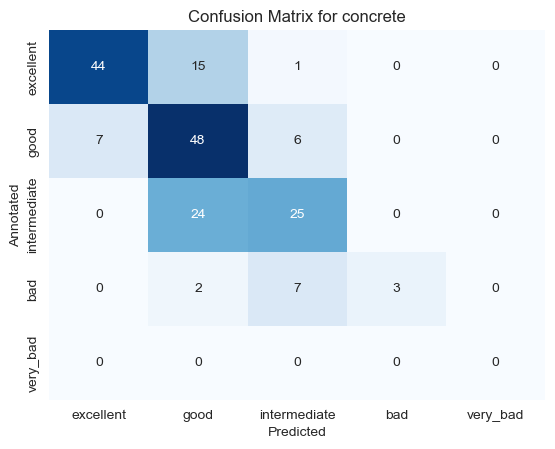

<Figure size 640x480 with 0 Axes>

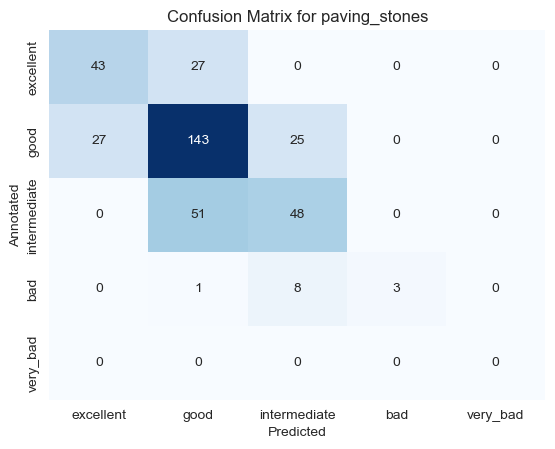

<Figure size 640x480 with 0 Axes>

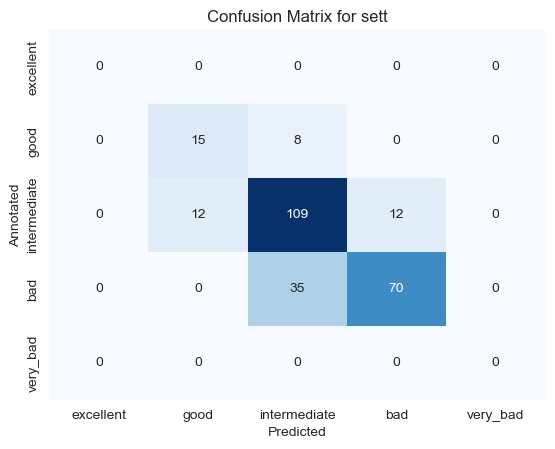

<Figure size 640x480 with 0 Axes>

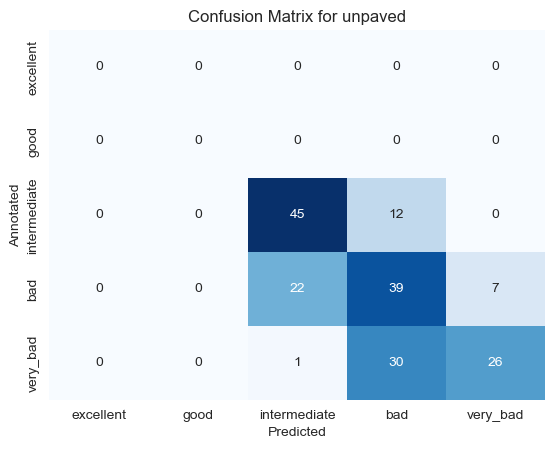

<Figure size 640x480 with 0 Axes>

In [104]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_label_true, _df.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [99]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")t
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 631
Count (true): 641
Precision: 0.95
Recall: 0.93
------------------------
Class: concrete
Count (pred): 205
Count (true): 191
Precision: 0.8
Recall: 0.85
------------------------
Class: sett
Count (pred): 267
Count (true): 267
Precision: 0.96
Recall: 0.96
------------------------
Class: paving_stones
Count (pred): 375
Count (true): 385
Precision: 0.98
Recall: 0.95
------------------------
Class: unpaved
Count (pred): 192
Count (true): 186
Precision: 0.94
Recall: 0.97
------------------------
------------------------
------------------------
Average precision: 0.92
Average recall: 0.93
Average F1-Score: 0.93
Accuracy: 0.94
